# Exploratory Data Analysis (EDA) of California Wildfires 1992 - 2020

In [19]:
# Import Libraries

# ML Basics plus sqlite3
import pandas as pd
import numpy as np
import sqlite3

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Geocoding Libraries
from shapely.geometry import Point
import geopandas as gpd
from geopy.geocoders import Nominatim

# Sci-Kit Learn Libraries
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Misc
import warnings
warnings.filterwarnings('ignore')

## Import and Clean Data

In [20]:
# Fire Program Analysis Fire-Occurrence Database (FPA FOD), queried for California only

# Original sqllite3 data source, removed from repo due to size
# conn = sqlite3.connect('Data/FPA_FOD_20221014.sqlite')
# fires_df = pd.read_sql("""SELECT * FROM fires WHERE STATE == 'CA'""", con=conn)

# Our updated dataframe
fires_df = pd.read_csv('Data/Updated CA Wildfire Database.csv')

In [21]:
fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251881 entries, 0 to 251880
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   OBJECTID                       251881 non-null  int64  
 1   Shape                          251881 non-null  object 
 2   FOD_ID                         251881 non-null  int64  
 3   FPA_ID                         251881 non-null  object 
 4   SOURCE_SYSTEM_TYPE             251881 non-null  object 
 5   SOURCE_SYSTEM                  251881 non-null  object 
 6   NWCG_REPORTING_AGENCY          251881 non-null  object 
 7   NWCG_REPORTING_UNIT_ID         251881 non-null  object 
 8   NWCG_REPORTING_UNIT_NAME       251881 non-null  object 
 9   SOURCE_REPORTING_UNIT          251881 non-null  object 
 10  SOURCE_REPORTING_UNIT_NAME     251881 non-null  object 
 11  LOCAL_FIRE_REPORT_ID           68579 non-null   float64
 12  LOCAL_INCIDENT_ID             

In [22]:
## The below code to reverse lookup County Name by lat/lon was taking too long to run and kept timing out. Instead, we will use a Random Forest Classifier
## to classify missing counties based on lat/lon. I'm keeping it in as it was a cool exercise.

# As we are interested in understanding which Counties experience more or less wildfire, we need to impute records that are missing the FIPS_NAME field.
# Fortunately we can use lat/lon to reverse lookup County Name for records with missing FIPS_NAME using the Nominatim API for OpenStreetMap
# This will allow the use of over 90K records that were missing this data
# If my back of napkin math is correct, this will run for over 24 hours to update all missing Counties but will only run once

# # Instantiate Nominatim object
# geolocator = Nominatim(user_agent="http")

# # Build a df with records missing FIPS_NAME(County)
# filtered_df = fires_df.loc[fires_df['FIPS_NAME'].isnull()]

# # Loop through the index of records missing the FIPS_NAME, perform a reverse lookup and update the df with the FIPS_NAME for that record
# counter = 0
# for index, row in filtered_df.iterrows():
#     print(f'Reverse Locating Missing County for {index}...')
#     fires_df['FIPS_NAME'].iloc[index] = geolocator.reverse((fires_df['LATITUDE'][index], fires_df['LONGITUDE'][index]),zoom=8)[0].split(',')[0]
#     counter+=1
#     print(counter)
#     if counter == 100:
#         # Write to file every 100 lookups in case kernel crashes
#         print('Writing to file...')
#         fires_df.to_csv('Data/Updated CA Wildfire Database.csv', index=False)
#         counter = 0

In [23]:
# # Let's train a Random Forest Classifier to predict County Name(FIPS_NAME) from the latitude and longitude of each fire,
# # and update our dataframe with these very educated guesses
# rfc = RandomForestClassifier(oob_score= True, n_estimators=2000)

# # We only want to train on records with a valid FIPS_NAME
# tmp_df = fires_df[fires_df.FIPS_NAME.notnull()]

# # We will predict/classify FIPS_NAME from LATITUDE and LONGITUDE
# X = tmp_df[['LATITUDE','LONGITUDE']]
# y = tmp_df['FIPS_NAME']

# # Fit the model and compute oob_score for validation that it is reasonably accurate
# rfc.fit(X, y)
# rfc.oob_score_

In [24]:
# # 99% is good enough for me! Likely the most accurate model that will come of this exercise :-)

# # Build a df with records missing FIPS_NAME(County)
# filtered_df = fires_df.loc[fires_df['FIPS_NAME'].isnull()]

# # Loop through the index of records missing the FIPS_NAME, predict the County based on lat/lon and update the record with the FIPS_NAME
# for index, row in filtered_df.iterrows():
#     print(f'Classifying FIPS_NAME(County) for record number {index}...')
#     fires_df['FIPS_NAME'].iloc[index] = rfc.predict([[fires_df['LATITUDE'][index], fires_df['LONGITUDE'][index]]])

In [25]:
# Let's save that back to our data file so that we don't have to run it everytime we restart the kernel
# fires_df.to_csv('Data/Updated CA Wildfire Database.csv', index=False)

In [26]:
# Let's keep only the features that are of interest
fires_df = fires_df[[
       'NWCG_REPORTING_UNIT_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'NWCG_GENERAL_CAUSE',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'FIPS_NAME']]

# and rename some features to be friendlier
fires_df.rename(columns={'FIPS_NAME':'COUNTY','NWCG_REPORTING_UNIT_NAME':'WILDLAND_NAME','NWCG_GENERAL_CAUSE':'CAUSE'}, inplace= True)

# # Split DISCOVERY_DATE into MM/DD, we already have FIRE_YEAR for YYYY
fires_df[['DISCOVERY_MONTH','DISCOVERY_DAY','DISCOVERY_YEAR']] = fires_df.DISCOVERY_DATE.str.split('/', expand= True)

# #Cast above as INT
fires_df[['DISCOVERY_MONTH','DISCOVERY_DAY','DISCOVERY_YEAR']] = fires_df[['DISCOVERY_MONTH','DISCOVERY_DAY','DISCOVERY_YEAR']].astype(int)

# Encode FIRE_SIZE_CLASS using Ordinal Encoder
encoder = OrdinalEncoder()
fires_df['FIRE_SIZE_CLASS'] = encoder.fit_transform(fires_df[['FIRE_SIZE_CLASS']])

In [27]:
fires_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251881 entries, 0 to 251880
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   WILDLAND_NAME    251881 non-null  object 
 1   FIRE_YEAR        251881 non-null  int64  
 2   DISCOVERY_DATE   251881 non-null  object 
 3   DISCOVERY_DOY    251881 non-null  int64  
 4   CAUSE            251881 non-null  object 
 5   FIRE_SIZE        251881 non-null  float64
 6   FIRE_SIZE_CLASS  251881 non-null  float64
 7   LATITUDE         251881 non-null  float64
 8   LONGITUDE        251881 non-null  float64
 9   COUNTY           251881 non-null  object 
 10  DISCOVERY_MONTH  251881 non-null  int64  
 11  DISCOVERY_DAY    251881 non-null  int64  
 12  DISCOVERY_YEAR   251881 non-null  int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 25.0+ MB


We've got 251,881 clean records to work with.

## Exploratory Data Analysis

### California Wildfire Frequency and Damage

One of our goals is to ascertain how a warming planet has affected the frequency and destructiveness of wildfire in California from 1992 - 2020. Let's perform some quick visualizations to answer that question at a high level:

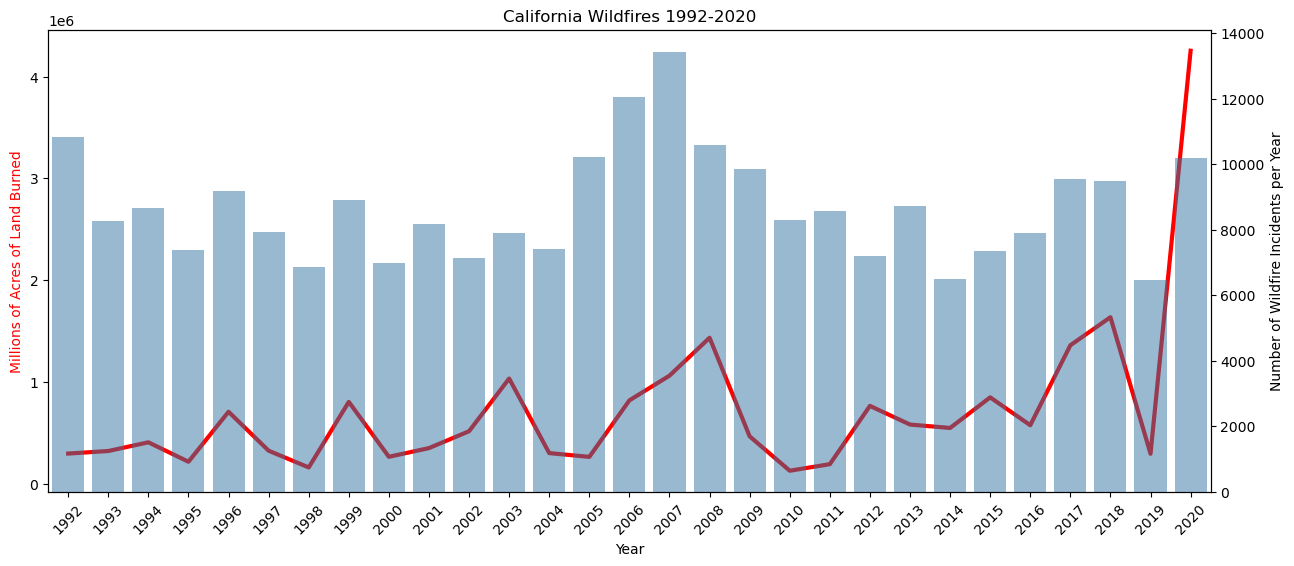

In [28]:
# Count of fires by year
count_by_year = fires_df.groupby(['FIRE_YEAR'])[['FIRE_SIZE']].count().reset_index()
# Sum of damage by year
damage_by_year = fires_df.groupby(['FIRE_YEAR'])[['FIRE_SIZE']].sum().reset_index()
# Average damage per year
avg_dmg_by_year = fires_df.groupby(['FIRE_YEAR'])[['FIRE_SIZE']].mean().reset_index()

f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(damage_by_year['FIRE_SIZE'], c='r', linewidth=3)
ax2 = ax.twinx()
sns.barplot(x= count_by_year['FIRE_YEAR'], y= count_by_year['FIRE_SIZE'], alpha=0.5)
ax.set_ylabel("Millions of Acres of Land Burned", c='r')
ax2.set_ylabel("Number of Wildfire Incidents per Year")
ax.set_xlabel("Year")
ax.set_title("California Wildfires 1992-2020")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show();

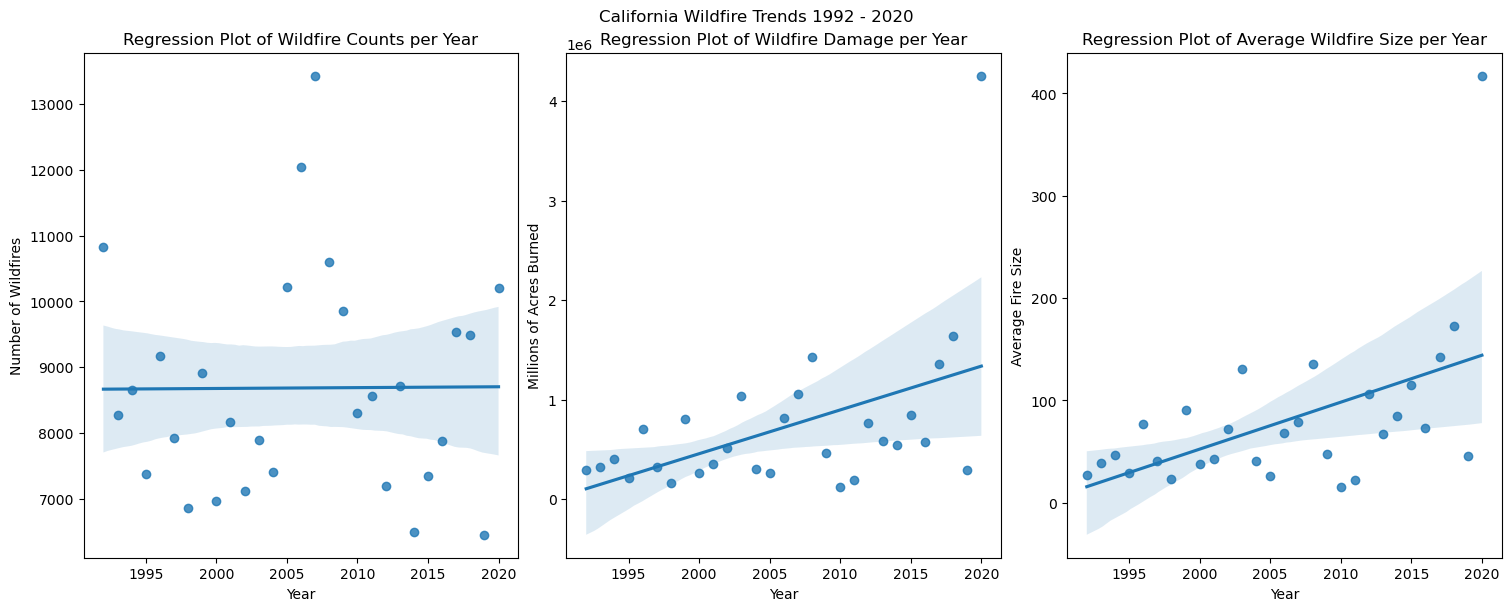

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, layout='constrained', figsize=(15,6))
fig.suptitle('California Wildfire Trends 1992 - 2020')
sns.regplot(count_by_year, x= 'FIRE_YEAR', y= 'FIRE_SIZE', ax=ax1)
ax1.set_title('Regression Plot of Wildfire Counts per Year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Wildfires')
sns.regplot(damage_by_year, x= 'FIRE_YEAR', y= 'FIRE_SIZE', ax=ax2)
ax2.set_title('Regression Plot of Wildfire Damage per Year')
ax2.set_ylabel('Millions of Acres Burned')
ax2.set_xlabel('Year');
sns.regplot(avg_dmg_by_year, x= 'FIRE_YEAR', y= 'FIRE_SIZE', ax=ax3)
ax3.set_title('Regression Plot of Average Wildfire Size per Year')
ax3.set_ylabel('Average Fire Size')
ax3.set_xlabel('Year');

While the variance in the data presents many questions in and of itself, it is apparent from this quick visualization that three things are true:
* The number or frequency of wildfires per year hasn't changed much between 1992 and 2020;
* The area burned by wildfire per year over this same period has increased dramatically;
* The average fire size is increasing, by definition.

From this we can conclude that wildfire has gotten more SEVERE over this time period, meaning that fires are larger and more destructive than they were prior to the study period.

### Causes of California Wildfire

What are the leading causes of wildfire in California?

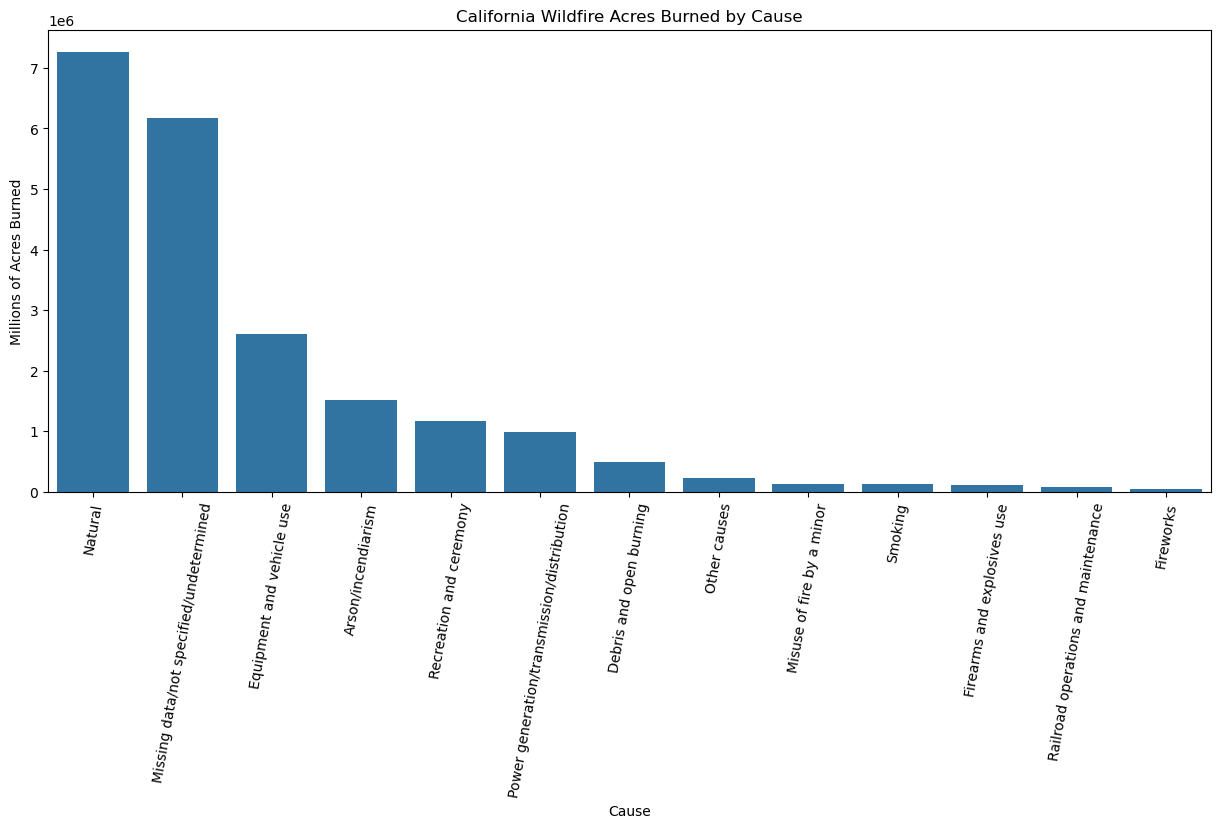

In [30]:
# Create a damage by cause dataframe
damage_by_cause = fires_df.groupby('CAUSE')[['FIRE_SIZE']].sum().sort_values(by='FIRE_SIZE', ascending=False).reset_index()
fig, ax = plt.subplots(figsize = (15,6))
sns.barplot(damage_by_cause, x='CAUSE', y='FIRE_SIZE')
plt.title('California Wildfire Acres Burned by Cause')
plt.ylabel('Millions of Acres Burned')
plt.xlabel('Cause')
plt.xticks(rotation=80);

The number one cause of acreage burned by wildfire is "Natural" which is understood to be Lightning. The fact that lightning sparked wildfires tend to occur in remote areas may contribute to the destructive nature of these wildfire starts. An potential area for future study. The fact that the second leading cause of wildfire is essentially "Unknown" movtivates me to build a model that can classify cause, which I will do in the modeling section of this study.

### Locations and Size of Wildfire

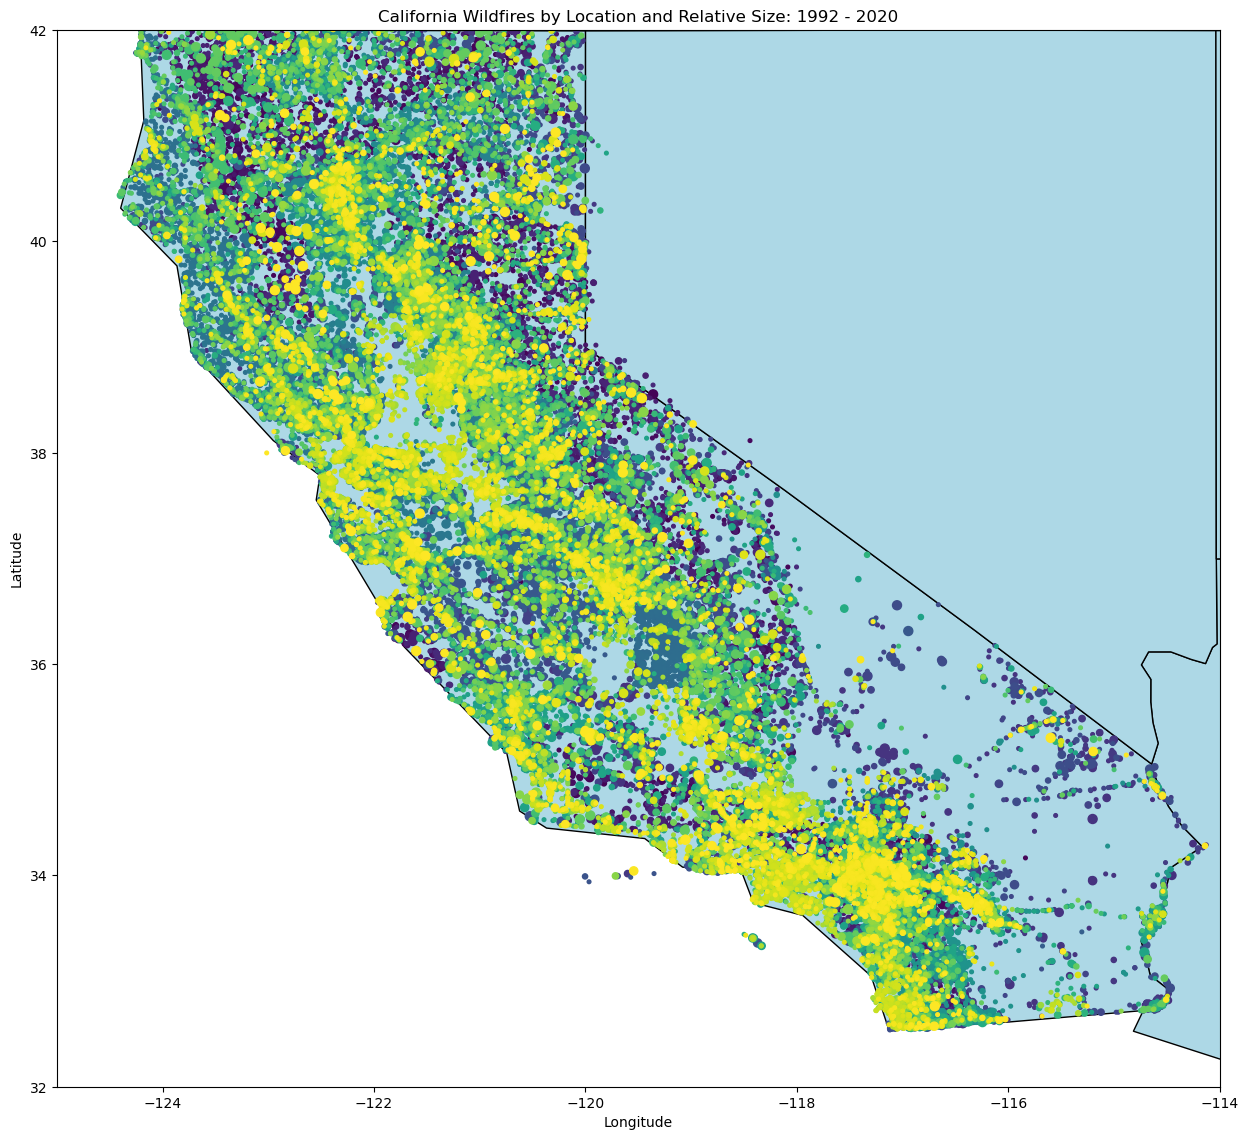

In [31]:
# Do some geospatial magic and chart wildfire locations and relative sizes

# Create geometry column
geometry = [Point(xy) for xy in zip(fires_df.LONGITUDE, fires_df.LATITUDE)]
gdf = gpd.GeoDataFrame(fires_df, geometry=geometry)

# Load world map
world = gpd.read_file('Data/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp')

# Create the geo bounding box for our basemap
bounding_box = [-125, 32, -114, 42] 
region = world.cx[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3]]

# Plot data
fig, ax = plt.subplots(figsize=(15, 15)) 
region.plot(ax=ax, color='lightblue', edgecolor='black') 
ax.set_xlim(bounding_box[0], bounding_box[2]) 
ax.set_ylim(bounding_box[1], bounding_box[3]) 
gdf.plot(ax=ax, marker='o', c=fires_df.FIRE_SIZE_CLASS, cmap='viridis', markersize=fires_df.FIRE_SIZE_CLASS*7)
ax.set_title('California Wildfires by Location and Relative Size: 1992 - 2020')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show();

We begin to see some patterns emerge in this visualization including clusters of severe wildfire and what seems to be a correlation between fire location and major roadways. 

Which counties have experienced the highest frequency of wildfire? Which counties have experienced the most wildfire damage?

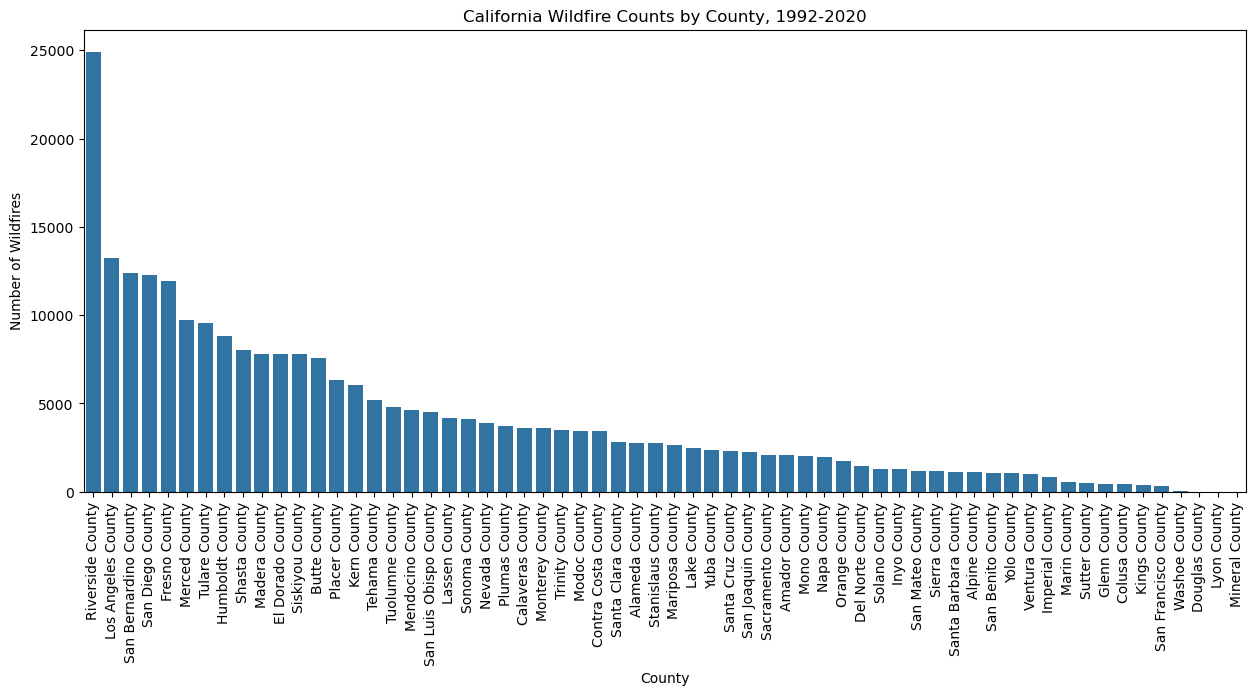

In [32]:
# Count of fires by County
fires_by_cty_cnt = fires_df.groupby('COUNTY')[['FIRE_SIZE']].count().sort_values(by='FIRE_SIZE', ascending= False)
# Acres burned by County
fires_by_cty_damage = fires_df.groupby('COUNTY')[['FIRE_SIZE']].sum().sort_values(by='FIRE_SIZE', ascending= False)

fig, ax = plt.subplots(figsize = (15, 6))
sns.barplot(fires_by_cty_cnt, x='COUNTY', y='FIRE_SIZE')
plt.title('California Wildfire Counts by County, 1992-2020')
plt.ylabel('Number of Wildfires')
plt.xlabel('County')
plt.xticks(rotation=90);

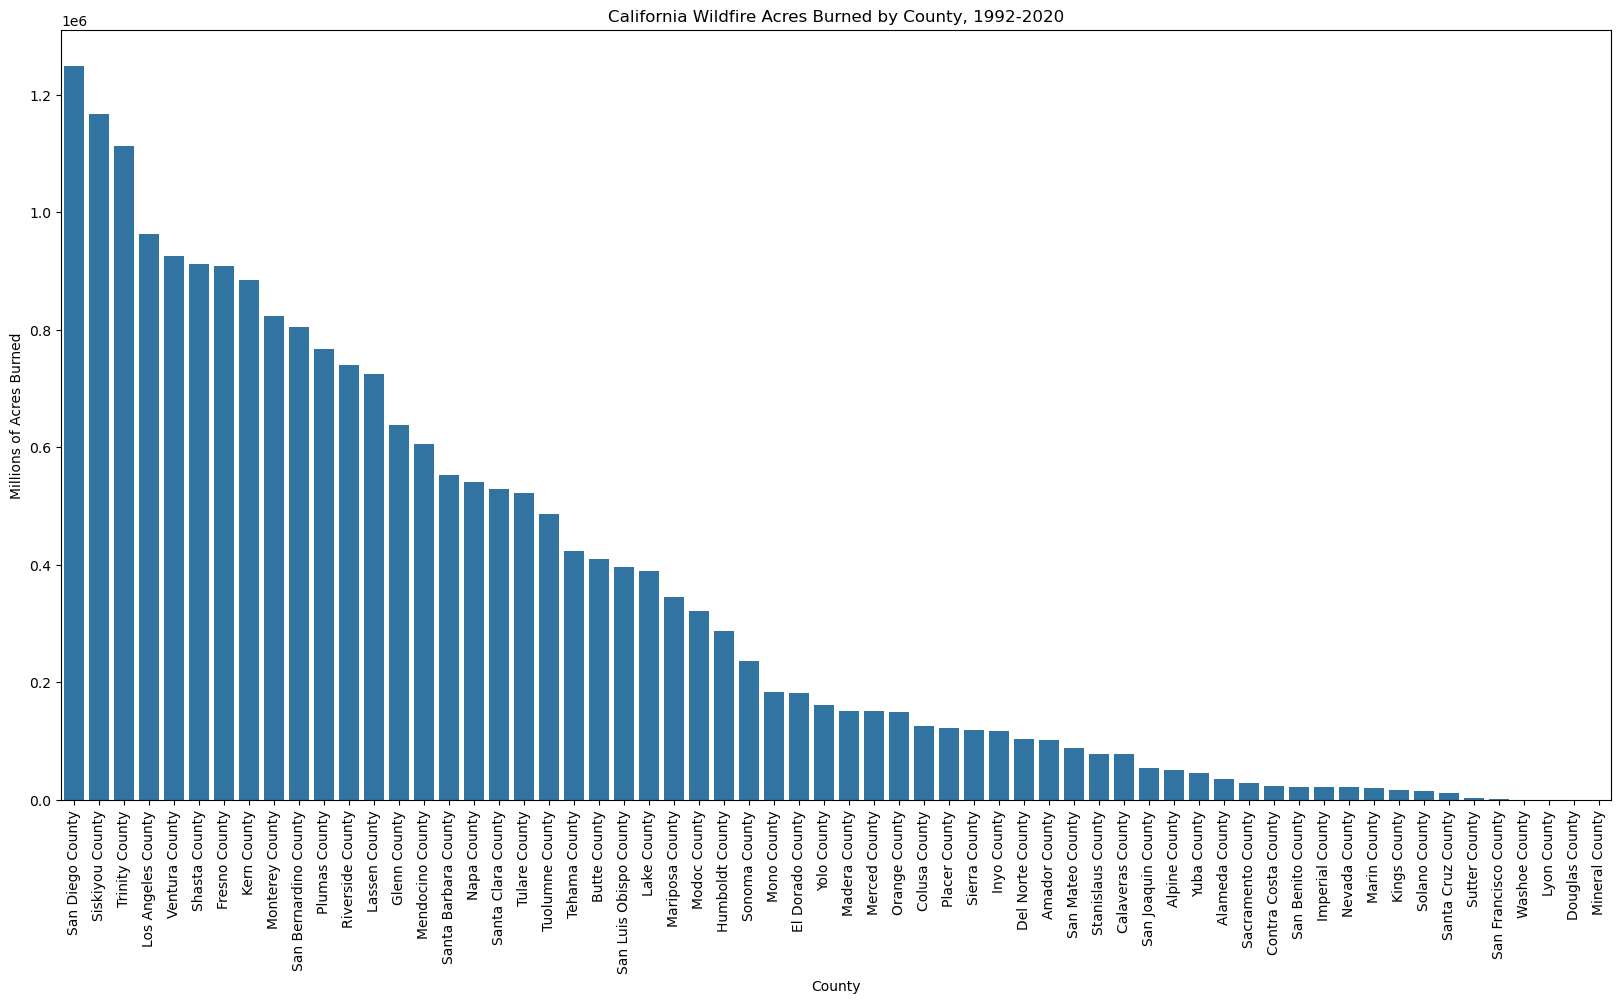

In [33]:
fig, ax = plt.subplots(figsize = (20,10))
sns.barplot(fires_by_cty_damage, x='COUNTY', y='FIRE_SIZE')
plt.title('California Wildfire Acres Burned by County, 1992-2020')
plt.ylabel('Millions of Acres Burned')
plt.xlabel('County')
plt.xticks(rotation=90);

It is interesting to note that the County with the highest rate of wildfire, Riverside, is 12th overall in acres burned during the study period. This too presents some interesting questions for further study related to ecosystem cover types and their propensity to burn. Why has San Diego suffered so much damage relative to the other counties?

### Wildfire Starts By Month

Somewhat common sensical, but we want to understand when the danger of a fire start is highest based on the month of the year.

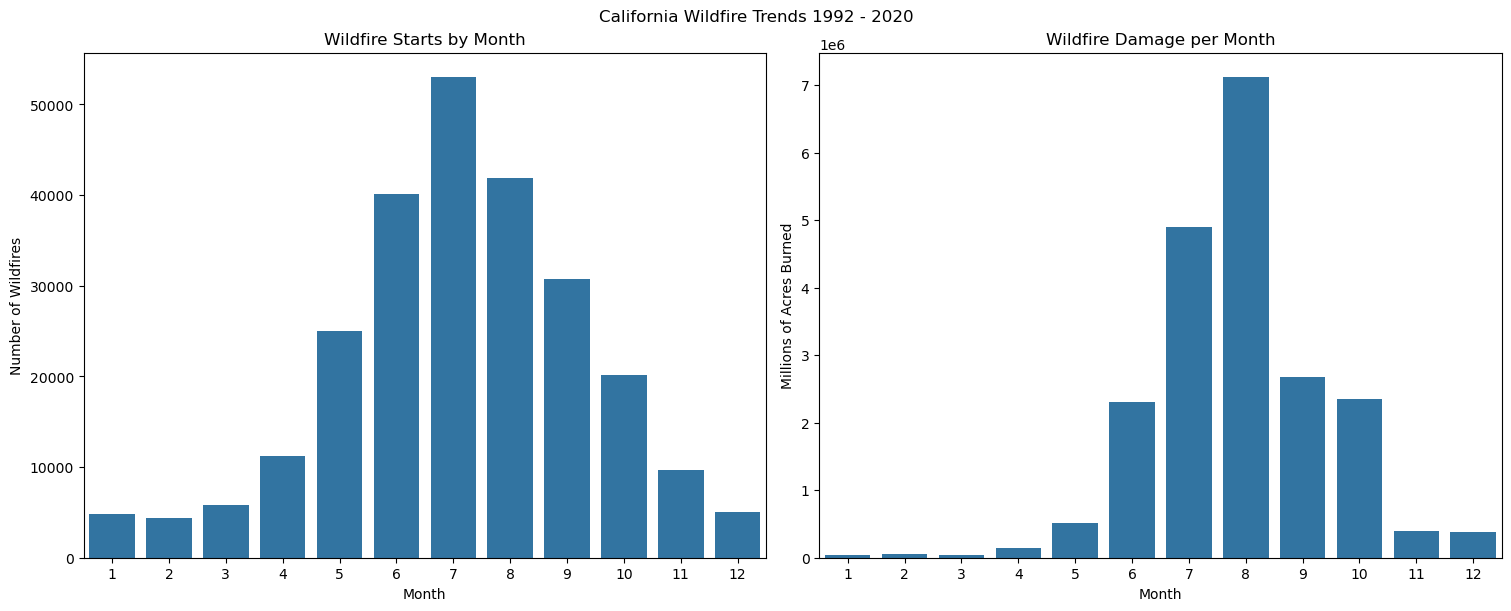

In [34]:
# Fires by month, 1992 - 2020
fires_by_month = fires_df.groupby('DISCOVERY_MONTH')[['FIRE_SIZE']].count().sort_values(by='DISCOVERY_MONTH')
# Acres burned by month
damage_by_month = fires_df.groupby('DISCOVERY_MONTH')[['FIRE_SIZE']].sum().sort_values(by='DISCOVERY_MONTH')

fig, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', figsize=(15,6))
fig.suptitle('California Wildfire Trends 1992 - 2020')
sns.barplot(fires_by_month, x= fires_by_month.index, y= 'FIRE_SIZE', ax=ax1)
ax1.set_title('Wildfire Starts by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Wildfires')
sns.barplot(damage_by_month, x= 'DISCOVERY_MONTH', y= 'FIRE_SIZE', ax=ax2)
ax2.set_title('Wildfire Damage per Month')
ax2.set_ylabel('Millions of Acres Burned')
ax2.set_xlabel('Month');

As expected, the summer months present the highest risk of wildfire starts and that the later in the summer they start, the more destructive they tend to be in terms of acres burned. November is the "official" start of rainy season in California, which would explain the precipitous drop in both wildfire starts and damage caused in the above visualizations.